# Convolutional autoencoder for MNIST

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import graphviz
import pydotplus
import pydot
from tensorflow.keras.datasets import mnist
import numpy as np

import warnings

In [2]:
def display_img(set1, set2=None, n=10, figsize=(20,4)):
    n = 10
    plt.figure(figsize=(20, 4))
    
    if set2 is not None:
        for i in range(1, n + 1):
    
            # Display original
            ax = plt.subplot(2, n, i)
            plt.imshow(set1[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display reconstruction
            ax = plt.subplot(2, n, i + n)
            plt.imshow(set2[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
    else:
        for i in range(1, n + 1):
            # Display original
            ax = plt.subplot(2, n, i)
            plt.imshow(set1[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show() 

In [37]:
class Encoder(tf.keras.layers.Layer):


    def __init__(self, filters, kernel_size, padding_pool, name="encoder"):
        super(Encoder, self).__init__(name=name)
        
        self.e1 = layers.Conv2D(filters,  kernel_size=kernel_size, activation='relu', padding='same')
        self.e2 = layers.MaxPooling2D((2, 2), padding=padding_pool)
        self.e3 = layers.Conv2D(filters/2,  kernel_size=kernel_size, activation='relu', padding='same')
        self.e4 = layers.MaxPooling2D((2, 2), padding=padding_pool)
        self.e5 = layers.Conv2D(filters/2,  kernel_size=kernel_size, activation='relu', padding='same')
        self.encoded = layers.MaxPooling2D((2, 2), padding=padding_pool)
        

    def call(self, inputs):
        x = self.e1(inputs)
        x = self.e2(x)
        x = self.e3(x)
        x = self.e4(x)
        x = self.e5(x)
        x = self.encoded(x)
        return x


class Decoder(tf.keras.layers.Layer):

    def __init__(self, filters, kernel_size, name="decoder"):
        super(Decoder, self).__init__(name=name)
        
        self.d1 = layers.Conv2D(filters/2, kernel_size=kernel_size, activation='relu', padding='same')
        self.d2 = layers.UpSampling2D((2, 2))
        self.d3 = layers.Conv2D(filters/2, kernel_size=kernel_size, activation='relu', padding='same')
        self.d4 = layers.UpSampling2D((2, 2))
        self.d5 = layers.Conv2D(filters, kernel_size=kernel_size, activation='relu')
        self.d6 = layers.UpSampling2D((2, 2))
        self.decoded = layers.Conv2D(1, kernel_size=kernel_size, activation='sigmoid', padding='same')
        

    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        x = self.d6(x)
        x = self.decoded(x)
        
        return x
    


class AutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, filters=16,  kernel_size=(3,3), padding_pool='same', name="autoencoder"):
        super().__init__(name=name)
        self.encoder = Encoder(filters=filters, kernel_size=kernel_size, padding_pool=padding_pool)
        self.decoder = Decoder(filters=filters, kernel_size=kernel_size)

    def call(self, inputs):
        z = self.encoder(inputs)
        z = self.decoder(z)
        
        return z
       

In [38]:
tf.keras.backend.clear_session()
autoencoder = AutoEncoder(filters=32,  kernel_size=(3,3), padding_pool='same')
input_img = tf.keras.Input(batch_size=10, shape=(28, 28, 1))
autoencoder(input_img).shape

TensorShape([10, 28, 28, 1])

In [39]:
autoencoder.build((10, 28, 28, 1))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  7264      
_________________________________________________________________
decoder (Decoder)            multiple                  9569      
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________


In [40]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [42]:
tf.keras.backend.clear_session()
autoencoder = AutoEncoder(filters=32, padding_pool='same')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/5
600/600 [==============================] - 57s 94ms/step - loss: 0.2545 - val_loss: 0.1113
Epoch 2/5
600/600 [==============================] - 55s 92ms/step - loss: 0.1086 - val_loss: 0.0997
Epoch 3/5
600/600 [==============================] - 56s 93ms/step - loss: 0.0993 - val_loss: 0.0940
Epoch 4/5
600/600 [==============================] - 56s 93ms/step - loss: 0.0945 - val_loss: 0.0905
Epoch 5/5
600/600 [==============================] - 55s 92ms/step - loss: 0.0910 - val_loss: 0.0883


In [43]:
decoded_imgs = autoencoder.predict(x_test)

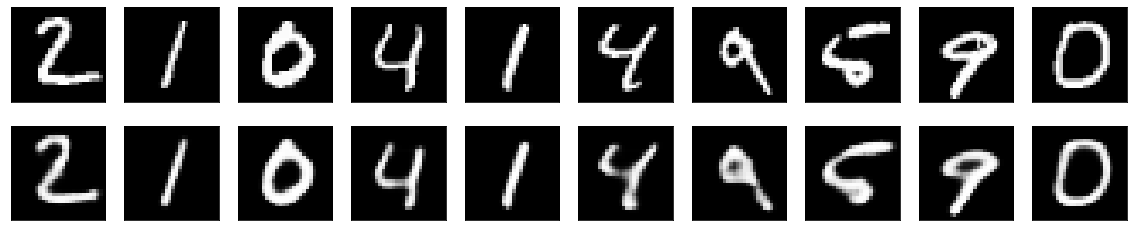

In [44]:
display_img(x_test, decoded_imgs )

In [45]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

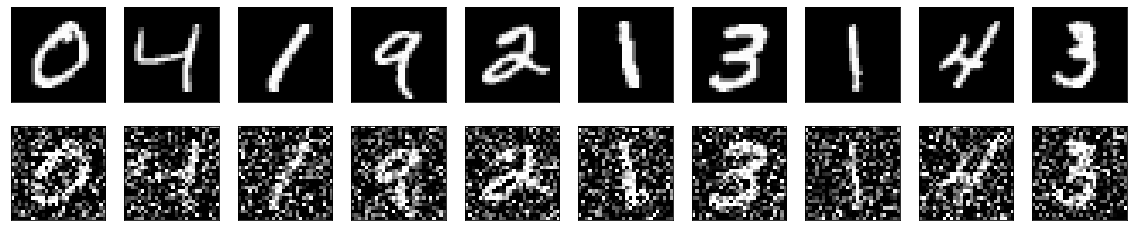

In [47]:
display_img(x_train, x_train_noisy)

In [48]:
tf.keras.backend.clear_session()
autoencoder = AutoEncoder(filters=32)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[])

Epoch 1/2
469/469 [==============================] - 55s 115ms/step - loss: 0.3000 - val_loss: 0.1601
Epoch 2/2
469/469 [==============================] - 53s 113ms/step - loss: 0.1542 - val_loss: 0.1389


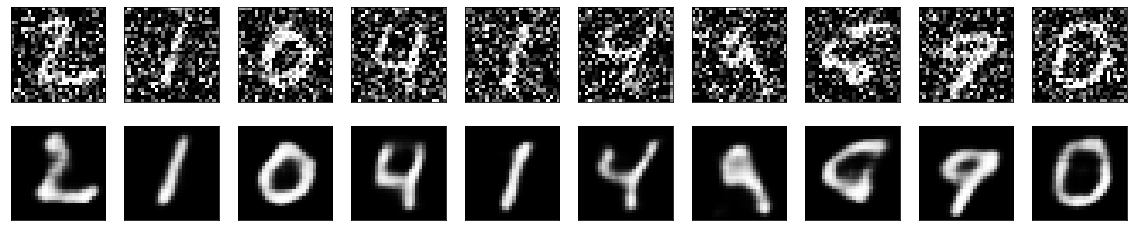

In [49]:
decoded_imgs = autoencoder.predict(x_test_noisy)
display_img(x_test_noisy, decoded_imgs )